**First of all, set environment variables and initialize spark context:**

In [1]:
%env SPARK_DRIVER_MEMORY=32g

from zoo.common.nncontext import *
sc = init_nncontext(init_spark_conf().setMaster("local[4]"))

env: SPARK_DRIVER_MEMORY=32g


Note that you have to allocate 32g memory to `SPARK_DRIVER_MEMORY` if you are about to finish the contents in this notebook. Perhaps there is no such memory left on your machine, see memory saving approach at the end of this notebook.

# Classifying movie reviews: a binary classification example

----

Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we 
will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

## The IMDB dataset
We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with the Keras API of Analytics Zoo. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [2]:
from zoo.pipeline.api.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(nb_words=10000)

The argument `nb_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [3]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [4]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"distracting ? a evil entertainment ? ? might ? might an films ? tries who because truly tries talent too br she man ? steven how determination will ? looks world's which can ? it screen that in have way gonna of of least ? want take toxic even paint ? similar ? japanese that ? would ? ? charles cover movie even ? moment ear ? ? not wanted involved ? ? ? ? quality ? ? ? point and sequences will ? bruckheimer how actually he way kinds ? genre fact fine l a either her ? ? movie ? cover and minute ? ending ? ? favorite ? of of private ? spoiler down remember and while ? ? having 200 while movie ? prove charisma pretty ? chuck and perspective seriously if a bed movie in ? cover was most five springer for to free film been but woods was showing director movie this ? ? display sinister much details to and ? ? many no there if i which explore is will ? paramount the we without on most ? eddie urban just the ? harold came even like cares charged ? be most comparison buck hollywood or mixed wel

We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later in the book).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [5]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [6]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [7]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. You may remember from the previous chapter that each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In the next chapter, you will learn formal principles to guide you in making these choices. 
For the time being, you will have to trust us with the following architecture choice: 
two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid activation so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Analytics zoo implementation, very similar to the MNIST example you saw previously:

In [8]:
from zoo.pipeline.api.keras import models
from zoo.pipeline.api.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [9]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

creating: createRMSprop
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [10]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

#### Accuracy checkout
_To checkout the behavior of this model in Keras, one could use following code accompanied with `matplotlib` library to draw the following `history` object_
    
    history = model.fit(partial_x_train,
                    partial_y_train,
                    nb_epoch=5,
                    batch_size=512,
                    validation_data=(x_val, y_val)
                    )
_After `fit` method finishes, the results are stored in `history` and thus could be visualized. Currently in Analytics zoo, `fit` method does not have any return. Results can only be checked via setting tensorboard._

To do training visualization, you can configure tensorboard in the model. The code of setting tensorboard and train is following, note that `set_tesnsorboard` need to be called before `fit` method:

In [11]:
import time
dir_name = '3-5 ' + str(time.ctime())
model.set_tensorboard('./', dir_name)
model.fit(partial_x_train,
          partial_y_train,
          nb_epoch=20,
          batch_size=512,
          validation_data=(x_val, y_val))

_INFO - Trained 512 records in 0.020173091 seconds. Throughput is 25380.344 records/second. Loss is 0.0092472015.
Top1Accuracy is Accuracy(correct: 8707, count: 10000, accuracy: 0.8707)_

Then result could be visualized in either of following ways: 

* Start tensorboard web interface in terminal by `tensorboard --logdir ./` and go to web browser url `localhost:port_number` as shown in your terminal.
* Use Analytics zoo built-in method `get_scalar_from_summary` with parameter `Loss` or `Validation` to get the array of scalar, then visualize via `matplotlib`.

We use the second approach here in order to directly show the result in this notebook.

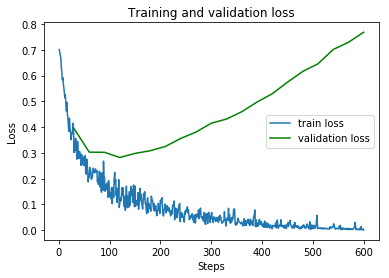

In [13]:
train_loss = np.array(model.get_train_summary('Loss'))
val_loss = np.array(model.get_validation_summary('Loss'))

import matplotlib.pyplot as plt
plt.plot(train_loss[:,0],train_loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='validation loss',color='green')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

The blue line is the training loss, while the green line is the validation loss. Note that your own results may vary 
slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch. That's what you would 
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that 
isn't the case for the validation loss: it seems to be optimized at about 1/5 of the total training epochs, which is 20/5 = 4. This is an example of what we were warning 
against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen 
before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we 
ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. In general, there is a range of techniques you can 
leverage to mitigate overfitting, which we will cover in the next chapter.

Let's train a new network from scratch for 4 epochs, then evaluate it on our test data:

In [14]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, nb_epoch=4, batch_size=512)

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


_INFO - Trained 512 records in 0.023978868 seconds. Throughput is 21352.133 records/second. Loss is 0.108611815._

In [15]:
results = model.evaluate(x_test, y_test)
results

[0.3063896596431732, 0.8806399703025818]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

## Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive 
by using the `predict` method:

#### Predict result
_In Keras, one could just call following code to predict the test data_

    model.predict(x_test)
_In Analytics zoo, the return of `predict` is RDD, so you need to call `collect` method to get the result:_

In [16]:
prediction = model.predict(x_test)
result = prediction.collect()
result

[array([0.6597656], dtype=float32),
 array([0.97529125], dtype=float32),
 array([1.39369495e-05], dtype=float32),
 array([0.9499197], dtype=float32),
 array([0.69558215], dtype=float32),
 array([0.98174447], dtype=float32),
 array([0.01318819], dtype=float32),
 array([0.9626703], dtype=float32),
 array([0.98742026], dtype=float32),
 array([0.00059057], dtype=float32),
 array([0.6133139], dtype=float32),
 array([0.978926], dtype=float32),
 array([0.99840707], dtype=float32),
 array([0.07168697], dtype=float32),
 array([0.89191675], dtype=float32),
 array([0.48994958], dtype=float32),
 array([0.02672931], dtype=float32),
 array([0.78033304], dtype=float32),
 array([0.07513892], dtype=float32),
 array([0.00686305], dtype=float32),
 array([0.04119945], dtype=float32),
 array([1.49263915e-05], dtype=float32),
 array([0.99980336], dtype=float32),
 array([0.8471216], dtype=float32),
 array([0.00010777], dtype=float32),
 array([0.9340031], dtype=float32),
 array([0.8214722], dtype=float32),
 a

## Further experiments


* We were using 2 hidden layers. Try to use 1 or 3 hidden layers and see how it affects validation and test accuracy.
* Try to use layers with more hidden units or less hidden units: 32 units, 64 units...
* Try to use the `mse` loss function instead of `binary_crossentropy`.
* Try to use the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be 
improved!

## Conclusions


Here's what you should take away from this example:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural 
network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will 
likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation, 
i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry 
about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data 
never-seen-before. Make sure to always monitor performance on data that is outside of the training set.


## \* Memory saving
To run this notebook based on codes above, you need 32g `SPARK_DRIVER_MEMORY`, which is a bit expensive. Following is a viable memory saving approach which could save your `SPARK_DRIVER_MEMORY` to 12g.

Taking a review of the time you have compiled the model, and prepared the `ndarray` type of datasets. And in old code above, the next step you would do is fit:

In [ ]:
model.fit(partial_x_train,
          partial_y_train,
          nb_epoch=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Just hold on here! Before you call this `fit` method, use following code to do the training to save the memory:

In [ ]:
from bigdl.util.common import to_sample_rdd

train = to_sample_rdd(partial_x_train, partial_y_train)
val = to_sample_rdd(x_val, y_val)

model.fit(train, None,
          nb_epoch=20,
          batch_size=512,
          validation_data=val)

This code zip the training data and label into RDD. The reason why it works is that every time when `fit` method takes `ndarray` as input, it transforms the `ndarray` to RDD and some memory is taken for cache in this process. And in this notebook, we use the same dataset as input repeatedly. If we call this operation only once and reuse the RDD afterwards, all the subsequential memory use would be saved.